
Building schedule and checking constraints...

[(0, 1), (0, 4), (0, 8), (0, 10), (0, 12), (1, 0), (1, 3), (1, 6), (1, 9), (1, 11), (2, 2), (2, 5), (2, 7), (2, 13)]
Time:  8.372122783999657


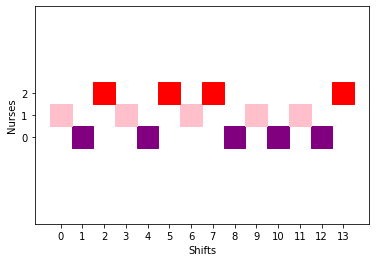

In [11]:
import boto3
from braket.aws import AwsDevice
from braket.devices import LocalSimulator
from braket.circuits import Circuit
import timeit

start = timeit.default_timer()

#Your statements here


#do we need this?
bell = Circuit().h(0).cnot(0, 1)
local_sim = LocalSimulator()
result = local_sim.run(bell, shots=1000).result()
counts = result.measurement_counts




my_bucket = "amazon-braket-qbraid-jobs"
my_prefix = "g00062902-40alumni-2eaus-2eedu"
s3_folder = (my_bucket, my_prefix)
device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")



#do we need this?
task = device.run(bell, s3_folder, shots=100)




from dwave.system import LeapHybridSampler
from dwave.system import DWaveSampler
from braket.ocean_plugin import BraketSampler, BraketDWaveSampler
from dimod import BinaryQuadraticModel
from collections import defaultdict
from copy import deepcopy
import matplotlib

#do we need this?
try:
    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle
except ImportError:
    matplotlib.use("agg")
    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle


total_nurses = 6

n_nurses = int(total_nurses/2) 
shifts_per_day = 2        # constant for now
n_days = 7        # constant for now
n_shifts = shifts_per_day * n_days
size = n_shifts * n_nurses

a = 3.5

lagrange_hard_shift = 1.3
workforce = 1     # constant for now
effort = 1        # constant for now

lagrange_soft_nurse = 0.3      
preference = 1                 # constant for now
min_duty_shifts = int(n_shifts/n_nurses)

def get_day_and_shift(shift_index):
    day, shift = divmod(shift_index, shifts_per_day)
    return day, shift

def get_index(nurse_index, shift_index):
    return nurse_index * n_shifts + shift_index


def get_nurse_and_shift(index):
    nurse_index, shift_index = divmod(index, n_shifts)
    return nurse_index, shift_index

J = defaultdict(int)
for nurse in range(n_nurses):
    for shift in range(n_shifts - 1):
        nurse_shift_1 = get_index(nurse, shift)
        nurse_shift_2 = get_index(nurse, shift+1)
        J[nurse_shift_1, nurse_shift_2] = a
        

Q = deepcopy(J)


for nurse in range(n_nurses):
    for shift in range(n_shifts):
        ind = get_index(nurse, shift)
        Q[ind, ind] += lagrange_hard_shift * (effort ** 2 - (2 * workforce * effort))

for shift in range(n_shifts):
    for nurse1 in range(n_nurses):
        for nurse2 in range(nurse1 + 1, n_nurses):
            ind1 = get_index(nurse1, shift)
            ind2 = get_index(nurse2, shift)
            Q[ind1, ind2] += 2 * lagrange_hard_shift * effort ** 2

for nurse in range(n_nurses):
    for shift in range(n_shifts):
        ind = get_index(nurse, shift)
        Q[ind, ind] += lagrange_soft_nurse * (preference ** 2 - (2 * min_duty_shifts * preference))

for nurse in range(n_nurses):
    for shift1 in range(n_shifts):
        for shift2 in range(shift1 + 1, n_shifts):
            ind1 = get_index(nurse, shift1)
            ind2 = get_index(nurse, shift2)
            Q[ind1, ind2] += 2 * lagrange_soft_nurse * preference ** 2

e_offset = (lagrange_hard_shift * n_shifts * workforce ** 2) + (lagrange_soft_nurse * n_nurses * min_duty_shifts ** 2)
bqm = BinaryQuadraticModel.from_qubo(Q, offset=e_offset)


sampler = LeapHybridSampler(token="DEV-0a303500c336963538ea6707935e6fb55fd8f12d")
# sampler = BraketDWaveSampler(s3_folder,'arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6')
results = sampler.sample(bqm)
# results = sampler.sample(bqm, label='Example - Nurse Scheduling')

smpl = results.first.sample

print("\nBuilding schedule and checking constraints...\n")
sched = [get_nurse_and_shift(j) for j in range(size) if smpl[j] == 1]


print(sched)


#we need to change this?
x,y = zip(*sched)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(y, x)
width = 1
height = 1
for a_y, a_x in sched:
    if a_y == 0:
        ax.add_patch(Rectangle(
            xy=(a_x-width/2, a_y-height/2) ,width=width, height=height,
            linewidth=1, color='purple', fill=True))
    elif a_y == 1:
        ax.add_patch(Rectangle(
            xy=(a_x-width/2, a_y-height/2) ,width=width, height=height,
            linewidth=1, color='pink', fill=True))
    elif a_y == 2:
        ax.add_patch(Rectangle(
            xy=(a_x-width/2, a_y-height/2) ,width=width, height=height,
            linewidth=1, color='red', fill=True))
    elif a_y == 3:
        ax.add_patch(Rectangle(
            xy=(a_x-width/2, a_y-height/2) ,width=width, height=height,
            linewidth=1, color='blue', fill=True))
    else:
        ax.add_patch(Rectangle(
            xy=(a_x-width/2, a_y-height/2) ,width=width, height=height,
            linewidth=1, color='green', fill=True))
ax.axis('equal')
ax.set_xticks(range(n_shifts)) #modify this for writing shift and day
ax.set_yticks(range(n_nurses))
ax.set_xlabel("Shifts")
ax.set_ylabel("Nurses")
plt.savefig("schedule.png")



# print("\nSchedule:\n")
# for n in range(n_nurses-1, -1, -1):
#     str_row = ""
#     for d in range(n_shifts):
#         outcome = "X" if (n, d) in sched else " "
#         if d > 9:
#             outcome += " "
#         str_row += "  " + outcome
#     print("Nurse ", n, str_row)

# str_header_for_output = " " * 11
# str_header_for_output += "  ".join(map(str, range(n_shifts)))
# print(str_header_for_output, "\n")

# print("Schedule saved as schedule.png.")
stop = timeit.default_timer()

print('Time: ', stop - start)  


In [6]:
js_sched = {"Monday":
	{"Morning":["Nurse1","Nurse8"],"Evening":["Nurse3","Nurse9"]},
 "Tuesday":
	{"Morning":["Nurse2","Nurse5"],"Evening":["Nurse4","Nurse8"]},
 "Wednesday":
	{"Morning":["Nurse1","Nurse5"],"Evening":["Nurse4","Nurse8"]},
 "Thursday":
	{"Morning":["Nurse3","Nurse7"],"Evening":["Nurse4","Nurse9"]},
 "Friday":
	{"Morning":["Nurse0","Nurse7"],"Evening":["Nurse2","Nurse6"]},
 "Saturday":
	{"Morning":["Nurse0","Nurse9"],"Evening":["Nurse1","Nurse6"]},
 "Sunday":
	{"Morning":["Nurse2","Nurse5"],"Evening":["Nurse3","Nurse7"]}
}